# Autocorrelograma y pruebas de ruido blanco para el IMAE de Costa Rica

Ejemplo numérico para ilustrar el uso del autocorrelograma y el autocorrelograma parcial.

**Nota** Para ejecutar este cuaderno se requiere el paquete `bccr`. Si no lo tiene, ejecute la siguiente celda

In [1]:
try:
    import bccr
except ImportError:
    print('Module bccr missing. Installing it now')
    !pip install bccr

In [2]:
from bccr import SW
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats.distributions import chi2
import os

figpath = "../figures/"

## Importamos los datos
La clase `ServicioWeb` permite obtener datos directamente del Banco Central de Costa Rica

Buscamos series que tenga "IMAE" en su DESCRIPCION, frecuencia mensual. Filtramos los resultados para ver solo las series en nivel, y dejamos solo aquellos qe tengan la palabra "IMAE" en su descripción

In [3]:
imaes = SW.buscar(todos='IMAE', frecuencia='M')
imaes = imaes[imaes.Unidad == 'Nivel']
imaes[imaes.descripcion.str.contains('IMAE')]

,DESCRIPCION,descripcion,Unidad,Medida,periodo
codigo,,,,,
913,"Node('/BCCR/Sector Real/IMAE con IEAT, Serie Original [913]')",Indice Mensual de Actividad Económica (IMAE) con la Industria Electronica de Alta Tecnologia (IEAT). Serie Original,Nivel,NO DEFINIDO,Mensual
914,"Node('/BCCR/Sector Real/IMAE con IEAT, Tendencia Ciclo [914]')",Índice Mensual de Actividad Económica (IMAE) con la Industria Electrónica de Alta Tecnología (IEAT). Serie Tendencia...,Nivel,NO DEFINIDO,Mensual
915,"Node('/BCCR/Sector Real/IMAE sin IEAT, Serie Original [915]')",Índice Mensual de Actividad Económica (IMAE) sin la Industria Electrónica de Alta Tecnología (IEAT). Serie Original,Nivel,NO DEFINIDO,Mensual
916,"Node('/BCCR/Sector Real/IMAE sin IEAT, Tendencia Ciclo [916]')",Índice Mensual de Actividad Económica (IMAE) sin la Industria Electrónica de Alta Tecnología (IEAT). Serie Tendencia...,Nivel,NO DEFINIDO,Mensual
22718,"Node('/BCCR/Sector Real/IMAE con IEAT, Desestacionalizada [22718]')",Índice Mensual de Actividad Económica (IMAE) con la Industria Electrónica de Alta Tecnología (IEAT). Serie Desestaci...,Nivel,NO DEFINIDO,Mensual
25158,"Node('/BCCR/Sector Real/IMAE con IEAT, Desestacionalizada [22718]/IMAE específico [25158]')",IMAE específico1991=100,Nivel,No definida,Mensual
22967,Node('/BCCR/Sector Real/IMAE sin Zona Franca Serie Original [22967]'),IMAE sin Zona Franca Serie Original,Nivel,NO DEFINIDO,Mensual
22970,Node('/BCCR/Sector Real/IMAE sin Zona Franca Serie Tendencia Ciclo [22970]'),IMAE sin Zona Franca Serie Original,Nivel,NO DEFINIDO,Mensual
35449,"Node('/BCCR/Sector Real/IMAE , Serie Original [35449]')","IMAE , Serie Original",Nivel,NO DEFINIDO,Mensual


De esta lista, escogemos los indicadores <strike>35449 (serie original) y 35553 (tendencia-ciclo)</strike> (éstas están discontinuadas, usarememos entonces las series 87703 y 87764, que de momentos no pueden encontrarse con bccr, pero sí descargarse). Descargamos los datos y cambiamos los nombres de las series.

In [4]:
imae = SW(Original=87703, Tendencia_ciclo=87764)

Graficamos las dos series para ver su dinamica.

<AxesSubplot:xlabel='fecha'>

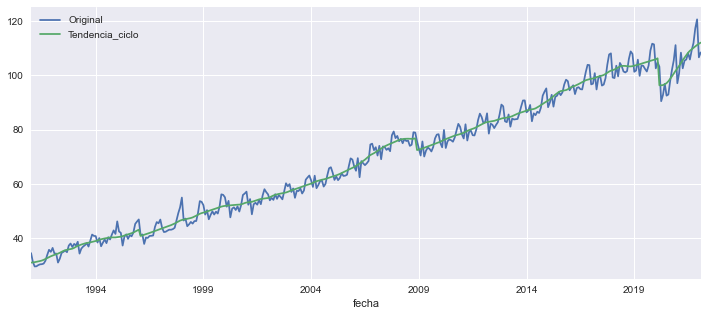

In [5]:
imae.plot(figsize=[12,5])

## Autocorrelograma

Obtenemos autocorrelogramas (48 rezagos, con intervalos de 95% de significancia (Bartlett)) para las series en nivel, primera diferencia, y diferencia estacional.

In [6]:
OPCIONES = dict(lags=48, alpha=0.05, title='')
plot_acf = sm.graphics.tsa.plot_acf
plot_pacf = sm.graphics.tsa.plot_pacf
log_imae = np.log(imae)

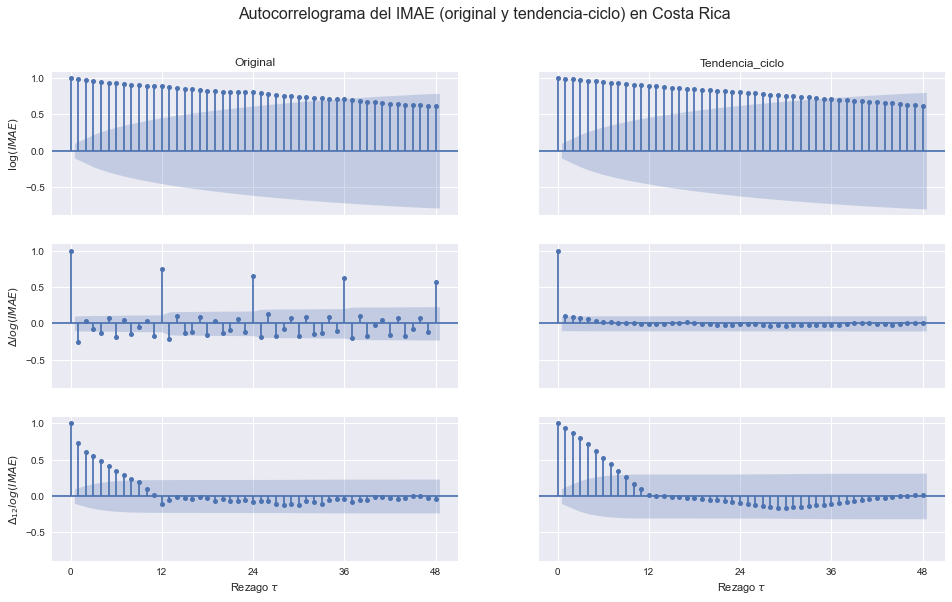

In [7]:
fig, axs = plt.subplots(3,2, figsize=[16,9], sharex=True, sharey=True)

for indic, ax in zip(imae, axs.T):
    plot_acf(log_imae[indic].dropna(), ax=ax[0], **OPCIONES);
    plot_acf(log_imae[indic].diff().dropna(), ax=ax[1], **OPCIONES);
    plot_acf(log_imae[indic].diff(12).dropna(), ax=ax[2], **OPCIONES);

for indic, ax in zip(imae, axs[0]):
    ax.set_title(indic)

for ax in axs[-1]:
    ax.set_xlabel(r'Rezago $\tau$')
    ax.set_xticks(np.arange(0,49,12));

axs[0,0].set_ylabel(r'$\log(IMAE)$')
axs[1,0].set_ylabel(r'$\Delta log(IMAE)$')
axs[2,0].set_ylabel(r'$\Delta_{12} log(IMAE)$')

fig.suptitle('Autocorrelograma del IMAE (original y tendencia-ciclo) en Costa Rica', size=16)
fig.savefig(figpath + 'IMAE-acf.pdf', bbox_inches='tight')    

## Autocorrelograma parcial

Repetimos el ejercicio, pero esta vez obtenemos autocorrelogramas parciales (48 rezagos, con intervalos de 95% de significancia) para las series en nivel, primera diferencia, y diferencia estacional.

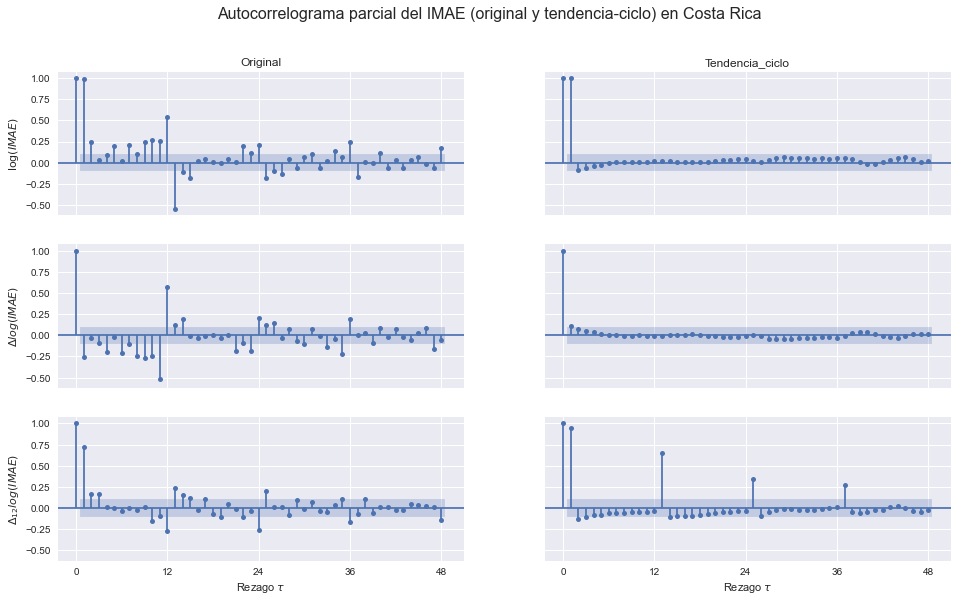

In [8]:
OPCIONES = dict(lags=48, alpha=0.05, title='', method='ols')

fig, axs = plt.subplots(3,2, figsize=[16,9], sharex=True, sharey=True)

for indic, ax in zip(imae, axs.T):
    plot_pacf(log_imae[indic].dropna(), ax=ax[0], **OPCIONES);
    plot_pacf(log_imae[indic].diff().dropna(), ax=ax[1], **OPCIONES);
    plot_pacf(log_imae[indic].diff(12).dropna(), ax=ax[2], **OPCIONES);

for indic, ax in zip(imae, axs[0]):
    ax.set_title(indic)

for ax in axs[-1]:
    ax.set_xlabel(r'Rezago $\tau$')
    ax.set_xticks(np.arange(0,49,12));

axs[0,0].set_ylabel(r'$\log(IMAE)$')
axs[1,0].set_ylabel(r'$\Delta log(IMAE)$')
axs[2,0].set_ylabel(r'$\Delta_{12} log(IMAE)$')

fig.suptitle('Autocorrelograma parcial del IMAE (original y tendencia-ciclo) en Costa Rica', size=16)
fig.savefig(figpath + 'IMAE-pacf.pdf', bbox_inches='tight')    

## Pruebas de ruido blanco

¿Es es crecimiento mensual del IMAE tendencia-ciclo un proceso ruido blanco?

In [9]:
growth = log_imae['Tendencia_ciclo'].diff().dropna()
T = growth.size  # número de datos
M = 7   # máximo número de rezagos
rezagos = np.arange(1, M+1)
alpha = 0.05  # significancia de los test

Calculamos las autocovarianzas, a partir de un rezago

In [10]:
rho = sm.tsa.acf(growth, fft=True, nlags=M)[1:] 

Calculamos el estadístico de Box-Pierce, para todos los rezagos desde el 1 hasta el 7

\begin{equation}
Q^{*} = T\sum_{j=1}^{m}\hat{\rho}_j^2 \; \overset{\text{asy}}{\sim} \; \chi^2_{m-k}
\end{equation}

In [11]:
Qstar = T * (rho ** 2).cumsum()

Calculamos el estadístico de Ljung-Box

\begin{equation}
Q = T(T+2)\sum_{j=1}^{m}\frac{\hat{\rho}_j^2}{T-j} \; \overset{\text{asy}}{\sim} \; \chi^2_{m-k}
\end{equation}

In [12]:
Q = T * (T+2) * ((rho ** 2)/(T-rezagos)).cumsum()

Calculamos los valores críticos, tomando en cuenta que $k=0$ porque los datos que estamos usando no son residuos

In [13]:
vcrits = np.array([chi2(k).ppf(1-alpha) for k in rezagos])

Con carácter informativo nada más, calculamos la autocorrelación parcial

In [14]:
rhop = sm.tsa.pacf(growth, nlags=M, method='ols')[1:]

Juntamos todos los resultados en una tabla de resumen.

In [15]:
resumen = pd.DataFrame({'AC':rho, 'PAC': rhop, 'Box-Pierce':Qstar, 'Ljung-Box':Q, f'$\chi^2(m-k)$': vcrits}, index=rezagos)
resumen.index.name = 'Rezagos'

resumen.round(3)

,AC,PAC,Box-Pierce,Ljung-Box,$\chi^2(m-k)$
Rezagos,,,,,
1,0.106,0.106,4.184,4.218,3.841
2,0.085,0.075,6.885,6.948,5.991
3,0.068,0.052,8.596,8.682,7.815
4,0.057,0.040,9.790,9.896,9.488
5,0.034,0.017,10.231,10.345,11.070
6,0.021,0.006,10.402,10.520,12.592
7,0.016,0.005,10.499,10.619,14.067


### Exportar datos
Finalmente, exportamos los datos para poder replicar este ejercicio con otros programas (Stata, EViews, R).

In [16]:
log_imae.to_csv('log_imae.csv')